In [1]:
!pip install pydub

# Library

In [2]:
import pandas as pd
import numpy as np
import cv2
import librosa
import librosa.display
import matplotlib.pyplot as plt
import seaborn as sns
import os
import tensorflow as tf
from keras.regularizers import l2
from sklearn.model_selection import train_test_split
from IPython.display import Audio
from multiprocessing import Pool
from pydub import AudioSegment
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import accuracy_score, confusion_matrix
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Dropout, Activation, GlobalAveragePooling2D, BatchNormalization
from keras.applications import VGG16, ResNet50
from keras.models import Model
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from collections import Counter

# Dataset

In [3]:
data = pd.read_csv("/content/drive/MyDrive/cv-corpus-14.0-2023-06-23/id/train.tsv", sep="\t")
data.head()

,client_id,path,sentence,up_votes,down_votes,age,gender,accents,variant,locale,segment
0,6ac0427a8caef565e3a800e844451a5dde7df70a144fae...,common_voice_id_25361388.mp3,Saya mendengarkan cerita membosankan dari tema...,2,0,NaN,NaN,NaN,NaN,id,NaN
1,6ac0427a8caef565e3a800e844451a5dde7df70a144fae...,common_voice_id_25361422.mp3,halo dunia!,2,0,NaN,NaN,NaN,NaN,id,NaN
2,6ac0427a8caef565e3a800e844451a5dde7df70a144fae...,common_voice_id_25377216.mp3,Sudah makan? sudah sholat...?,2,0,NaN,NaN,NaN,NaN,id,NaN
3,6ac0427a8caef565e3a800e844451a5dde7df70a144fae...,common_voice_id_25378528.mp3,mau pergi kemana hari ini?,2,0,NaN,NaN,NaN,NaN,id,NaN
4,6ac0427a8caef565e3a800e844451a5dde7df70a144fae...,common_voice_id_25378794.mp3,udah keluar hasil testnya?,2,0,NaN,NaN,NaN,NaN,id,NaN


# Feature Selection and Missing Value

In [4]:
print(data.shape)
data.isnull().sum()

(4967, 11)


client_id        0
path             0
sentence         0
up_votes         0
down_votes       0
age           1930
gender        1930
accents       4967
variant       4967
locale           0
segment       4967
dtype: int64

In [5]:
data = data[["path", "gender"]]
data = data.dropna()
print(data.shape)
data.isnull().sum()

(3037, 2)


path      0
gender    0
dtype: int64

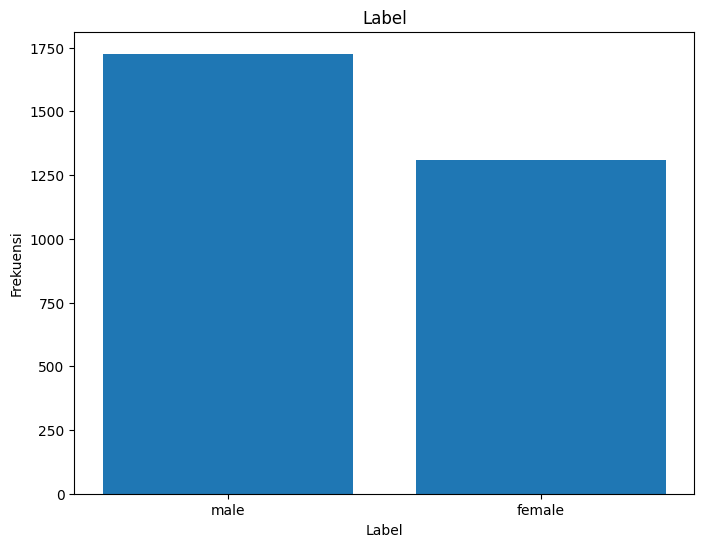

In [6]:
def fr_label(data, title):
  label_counts = Counter(data)
  label_names = list(label_counts.keys())
  label_frequencies = list(label_counts.values())
  plt.figure(figsize=(8, 6))
  plt.bar(label_names, label_frequencies)
  plt.xlabel('Label')
  plt.ylabel('Frekuensi')
  plt.title(title)
  plt.show()

fr_label(data["gender"], "Label")

# Audio Processing with Parallel Computing

In [7]:
def audio_to_spectrogram(mp3_path):
  audio = AudioSegment.from_mp3(mp3_path)
  audio.export('temp_audio.wav', format='wav')
  y, sr = librosa.load('temp_audio.wav')
  spectrogram = librosa.feature.melspectrogram(y=y, sr=sr)
  log_spectrogram = librosa.power_to_db(spectrogram, ref=np.max)
  image_path = mp3_path.replace('.mp3', '.png').replace('clips', 'spectrogram')
  plt.figure(figsize=(5, 3))
  librosa.display.specshow(log_spectrogram, sr=sr, x_axis=None, y_axis=None)
  plt.axis('off')
  plt.title('')
  plt.savefig(image_path, bbox_inches='tight', pad_inches=0)
  plt.close()

def process_audio(mp3_path):
  path_cek = mp3_path.replace('.mp3', '.png')
  if not os.path.exists("/content/drive/MyDrive/cv-corpus-14.0-2023-06-23/id/spectrogram/" + path_cek):
    audio_to_spectrogram("/content/drive/MyDrive/cv-corpus-14.0-2023-06-23/id/clips/" + mp3_path)
  img = cv2.imread("/content/drive/MyDrive/cv-corpus-14.0-2023-06-23/id/spectrogram/" + path_cek)
  img = cv2.resize(img, (128, 128))
  return img

pool = Pool(processes=30)
image_list = pool.map(process_audio, data["path"])

pool.close()
pool.join()
if os.path.exists('temp_audio.wav'):
  os.remove('temp_audio.wav')

# Image Processing

In [8]:
def labelss(row, lbl):
  li = []
  for i in range(row):
    if lbl[i] == "male":
      li.append(1)
    elif lbl[i] == "female":
      li.append(0)
  return li

labels = np.array(labelss(len(data["gender"]), data["gender"].tolist()))

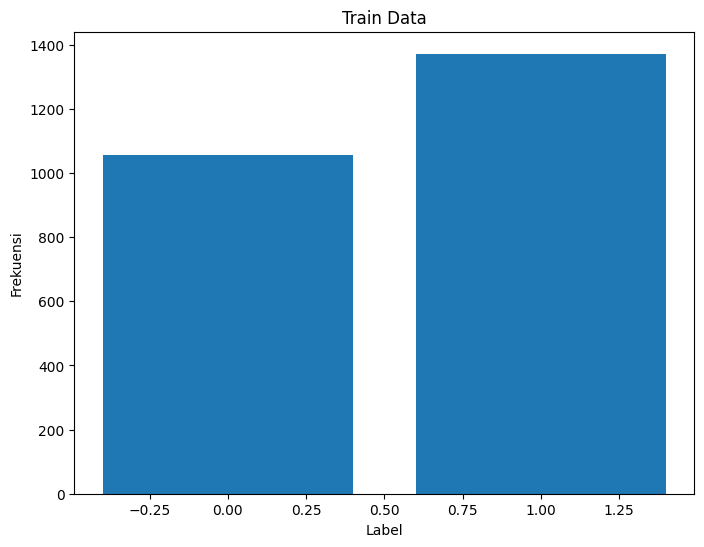

In [9]:
images = np.array(image_list)
train_image, test_image, train_label, test_label = train_test_split(images, labels, test_size=0.2, random_state=42)
fr_label(train_label, "Train Data")

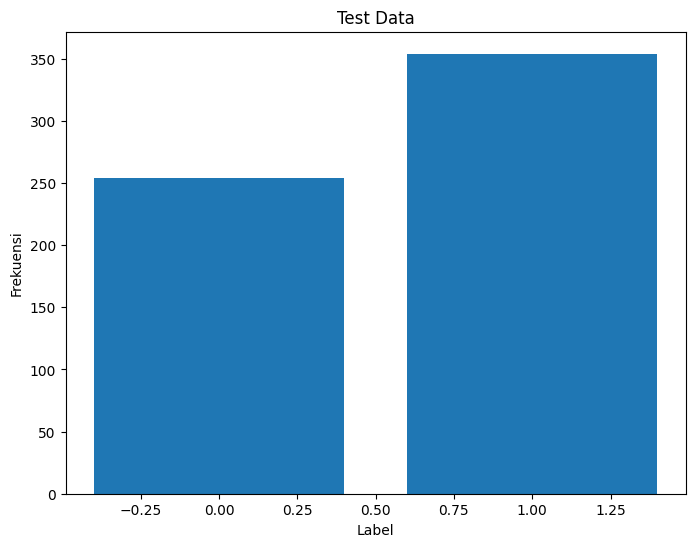

In [10]:
fr_label(test_label, "Test Data")

In [11]:
train_image = train_image / 255
test_image = test_image / 255
train_label = to_categorical(train_label)
test_label = to_categorical(test_label)
print("Train Image Shape:", train_image.shape)
print("Test Image Shape:", test_image.shape)
print("Train Labels Shape:", train_label.shape)
print("Test Labels Shape:", test_label.shape)

Train Image Shape: (2429, 128, 128, 3)
Test Image Shape: (608, 128, 128, 3)
Train Labels Shape: (2429, 2)
Test Labels Shape: (608, 2)


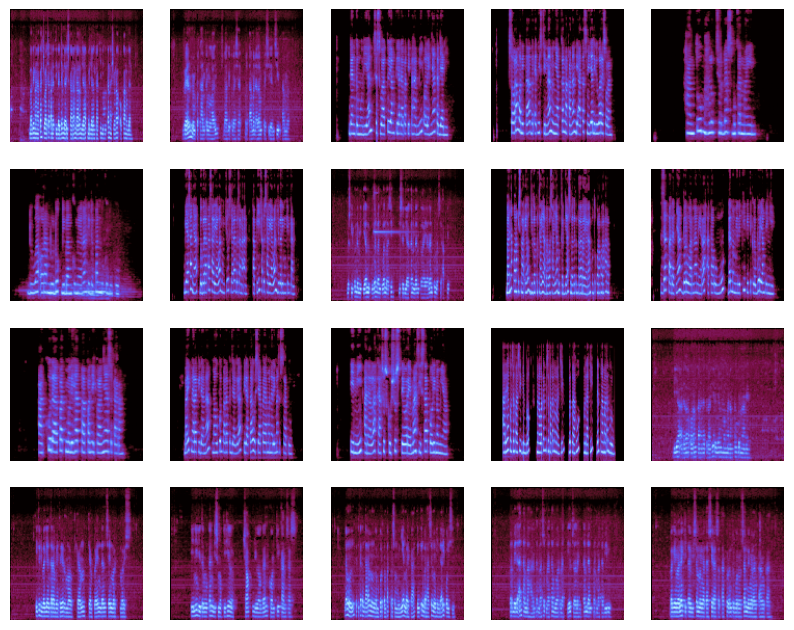

In [12]:
plt.figure(figsize=(10, 10))
for i in range(20):
  plt.subplot(5, 5, i+1)
  plt.imshow(train_image[i])
  plt.axis('off')
plt.show()

# Models

## Simple CNN

In [13]:
cnn_model = Sequential()
cnn_model.add(Conv2D(filters=16, kernel_size=2, activation='relu', input_shape=(128, 128, 3)))
cnn_model.add(MaxPool2D(pool_size=2))
cnn_model.add(Conv2D(filters=32, kernel_size=2, activation='relu'))
cnn_model.add(MaxPool2D(pool_size=2))
cnn_model.add(Conv2D(filters=64, kernel_size=2, activation='relu'))
cnn_model.add(MaxPool2D(pool_size=2))
cnn_model.add(Flatten())
cnn_model.add(Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.1)))
cnn_model.add(Dropout(0.5))
cnn_model.add(BatchNormalization())
cnn_model.add(Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.1)))
cnn_model.add(Dropout(0.5))
cnn_model.add(Dense(2, activation='sigmoid'))
cnn_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
cnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 127, 127, 16)      208       
                                                                 
 max_pooling2d (MaxPooling2  (None, 63, 63, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 62, 62, 32)        2080      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 31, 31, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 30, 30, 64)        8256      
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 15, 15, 64)        0

In [14]:
history = cnn_model.fit(train_image, train_label, epochs=5, batch_size=32, validation_split=0.2)

Epoch 1/5
61/61 [==============================] - 20s 34ms/step - loss: 25.6700 - accuracy: 0.9279 - val_loss: 3.2879 - val_accuracy: 0.9959
Epoch 2/5
61/61 [==============================] - 1s 15ms/step - loss: 0.9678 - accuracy: 0.9949 - val_loss: 0.5377 - val_accuracy: 0.9712
Epoch 3/5
61/61 [==============================] - 1s 16ms/step - loss: 0.1665 - accuracy: 0.9949 - val_loss: 0.3435 - val_accuracy: 0.9959
Epoch 4/5
61/61 [==============================] - 1s 18ms/step - loss: 0.2049 - accuracy: 0.9943 - val_loss: 0.2068 - val_accuracy: 0.9979
Epoch 5/5
61/61 [==============================] - 1s 17ms/step - loss: 0.1252 - accuracy: 0.9964 - val_loss: 0.2104 - val_accuracy: 0.9897


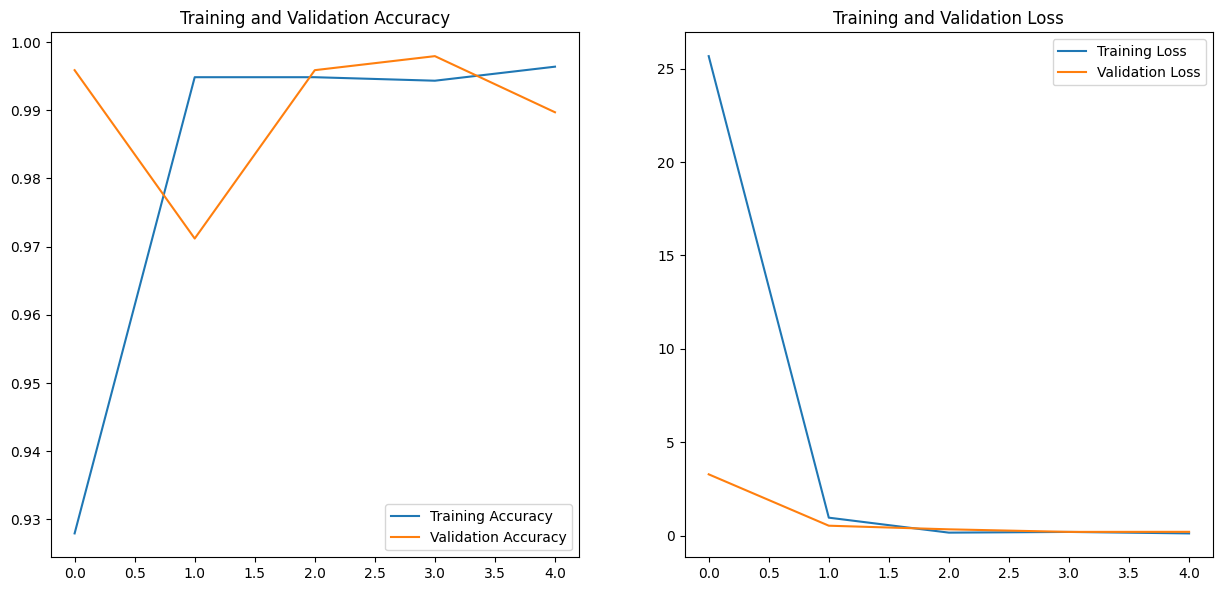

In [15]:
epochs_range = range(5)

plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, history.history['accuracy'], label='Training Accuracy')
plt.plot(epochs_range, history.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(epochs_range, history.history['loss'], label='Training Loss')
plt.plot(epochs_range, history.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

19/19 [==============================] - 0s 5ms/step


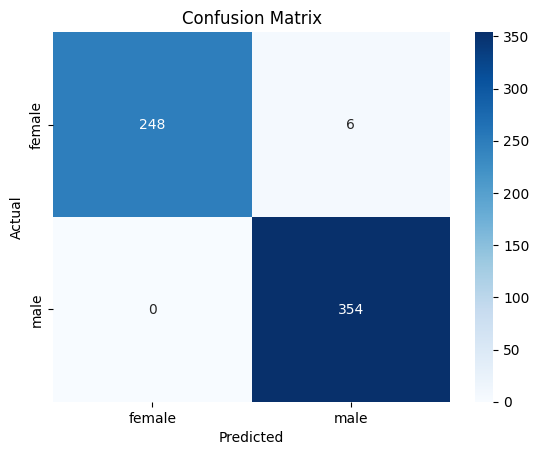

In [16]:
test_loss, test_acc = cnn_model.evaluate(test_image, test_label)
pred_label = cnn_model.predict(test_image)
cnn_cm = confusion_matrix(np.argmax(test_label, axis=1), np.argmax(pred_label, axis=1))
sns.heatmap(cnn_cm, annot=True, fmt='d', cmap='Blues', xticklabels=["female", "male"], yticklabels=["female", "male"])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [17]:
print("Akurasi:", test_acc)

Akurasi: 0.9901315569877625


## VGG16

In [18]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
vgg_model = Sequential()
vgg_model.add(base_model)
vgg_model.add(Flatten())
vgg_model.add(Dense(512, activation='relu'))
vgg_model.add(Dropout(0.5))
vgg_model.add(BatchNormalization())
vgg_model.add(Dense(512, activation='relu'))
vgg_model.add(Dropout(0.5))
vgg_model.add(Dense(2, activation='sigmoid'))
vgg_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
vgg_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten_1 (Flatten)         (None, 8192)              0         
                                                                 
 dense_3 (Dense)             (None, 512)               4194816   
                                                                 
 dropout_2 (Dropout)         (None, 512)               0         
                                                                 
 batch_normalization_1 (Bat  (None, 512)               2048      
 chNormalization)                                                
                                                                 
 dense_4 (Dense)             (None, 512)               262656    
                                                      

In [19]:
history = vgg_model.fit(train_image, train_label, epochs=5, batch_size=32, validation_split=0.2)

Epoch 1/5
61/61 [==============================] - 26s 231ms/step - loss: 0.2937 - accuracy: 0.8641 - val_loss: 3.2714 - val_accuracy: 0.8086
Epoch 2/5
61/61 [==============================] - 9s 143ms/step - loss: 0.0406 - accuracy: 0.9933 - val_loss: 0.0206 - val_accuracy: 0.9938
Epoch 3/5
61/61 [==============================] - 9s 146ms/step - loss: 0.0354 - accuracy: 0.9928 - val_loss: 0.0775 - val_accuracy: 0.9630
Epoch 4/5
61/61 [==============================] - 10s 157ms/step - loss: 0.0279 - accuracy: 0.9954 - val_loss: 183.0359 - val_accuracy: 0.9897
Epoch 5/5
61/61 [==============================] - 10s 157ms/step - loss: 0.0287 - accuracy: 0.9959 - val_loss: 17.7584 - val_accuracy: 0.9897


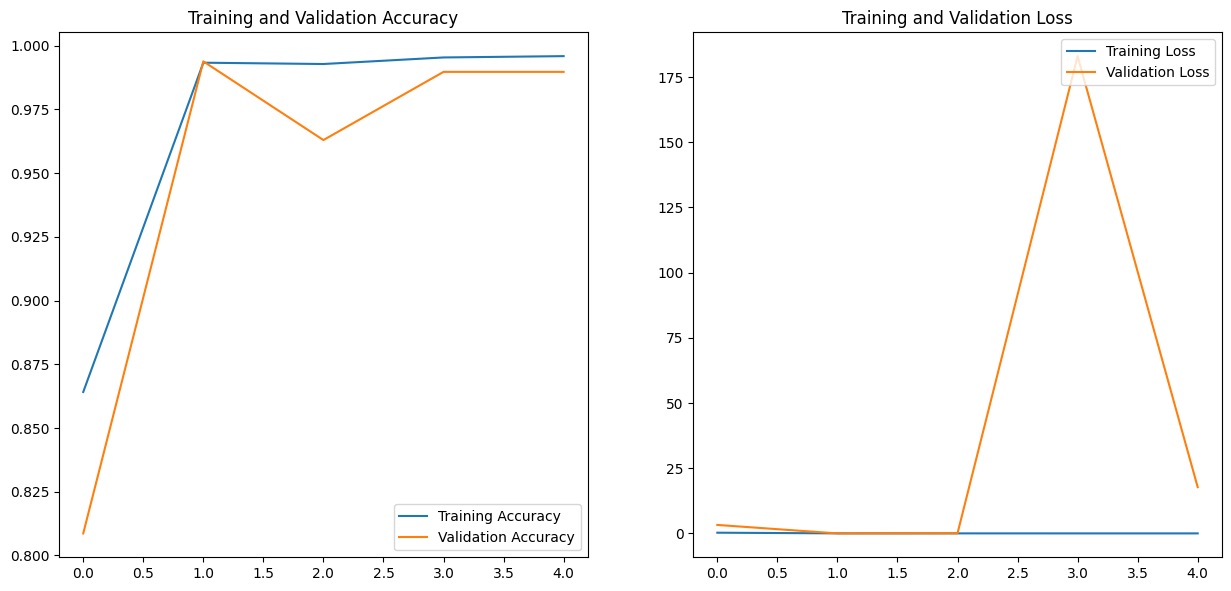

In [20]:
epochs_range = range(5)

plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, history.history['accuracy'], label='Training Accuracy')
plt.plot(epochs_range, history.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(epochs_range, history.history['loss'], label='Training Loss')
plt.plot(epochs_range, history.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

19/19 [==============================] - 1s 40ms/step


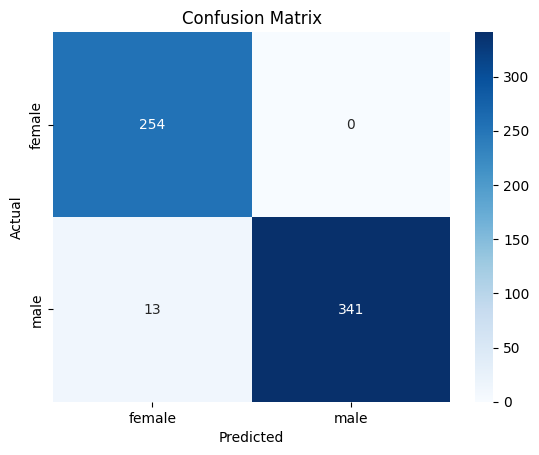

In [21]:
test_loss, test_acc = vgg_model.evaluate(test_image, test_label)
pred_label = vgg_model.predict(test_image)
vgg_cm = confusion_matrix(np.argmax(test_label, axis=1), np.argmax(pred_label, axis=1))
sns.heatmap(vgg_cm, annot=True, fmt='d', cmap='Blues', xticklabels=["female", "male"], yticklabels=["female", "male"])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [22]:
print("Akurasi:", test_acc)

Akurasi: 0.9802631735801697


In [23]:
def prediksi(mp3_path, model):
  audio = AudioSegment.from_mp3(mp3_path)
  audio.export('temp_audio.wav', format='wav')
  y, sr = librosa.load('temp_audio.wav')
  spectrogram = librosa.feature.melspectrogram(y=y, sr=sr)
  log_spectrogram = librosa.power_to_db(spectrogram, ref=np.max)
  plt.figure(figsize=(6, 4))
  librosa.display.specshow(log_spectrogram, sr=sr, x_axis='time', y_axis='mel')
  plt.colorbar(format='%+2.0f dB')
  plt.title('Mel Spectrogram')
  plt.savefig("audio.png", bbox_inches='tight', pad_inches=0)
  plt.close()
  img = np.array([cv2.resize(cv2.imread("audio.png"), (128, 128))])
  pred = np.argmax(model.predict(img))
  if os.path.exists('temp_audio.wav'):
    os.remove('temp_audio.wav')
  if os.path.exists('audio.png'):
    os.remove('audio.png')
  if pred == 1:
    return "male"
  elif pred == 0:
    return "female"

In [24]:
audio = "/content/drive/MyDrive/cv-corpus-14.0-2023-06-23/id/clips/common_voice_id_27389019.mp3"
Audio(audio)

In [28]:
prediksi(audio, vgg_model)

1/1 [==============================] - 1s 931ms/step


'female'

In [26]:
audio2 = "/content/drive/MyDrive/cv-corpus-14.0-2023-06-23/id/clips/common_voice_id_20900234.mp3"
Audio(audio2)

In [31]:
prediksi(audio2, cnn_model)

1/1 [==============================] - 0s 34ms/step


'male'